In [13]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import truncnorm
from numba import cuda, vectorize, jit, njit, int64, float32, float64
from numba.pycc import CC

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [5]:
A = [2, 5, 10, 3, 8]

In [7]:
@vectorize([float32(int64)], nopython=True) # used nopython = True to ensure the code does not fallback to object mode.
def log(a):
    c =  np.log(a)
    return c
print(log(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


In [8]:
@vectorize([float32(int64)], nopython=True)
def exp(a):
    c = np.exp(a)
    return c

print(exp(A))

[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [41]:
@jit(nopython=True)
# at first I tried to use the scipy function stats.truncnorm but it doesn't work with numba
def gauss(n = 100000):
    b = np.array([np.random.normal(loc=1.0, scale=1.0) for i in range(n)])
    return np.interp(b, (b.min(), b.max()), (-3, +3)) #to scale to the [-3, 3] interval

gauss()

array([ 0.88561332, -0.63985049, -1.44067321, ..., -0.37165714,
        1.85360974, -0.01325399])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

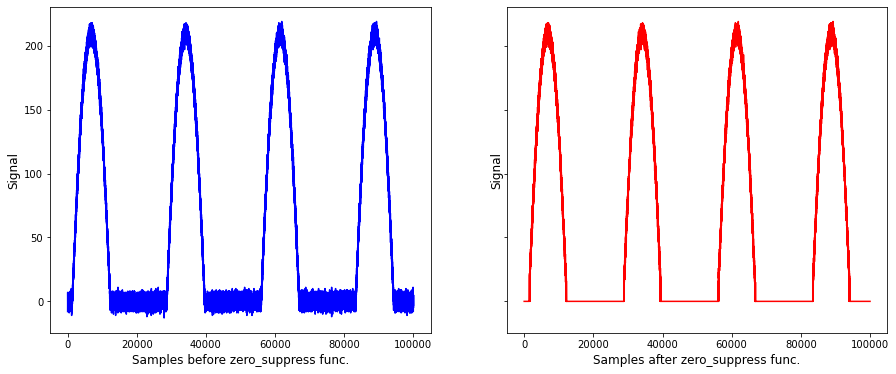

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize(nopython=True)
def zero_suppress(samples, threshold):
    if np.abs(samples) >= threshold:
        return samples
    else:
        return 0.0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
#fig.subplots_adjust(wspace=0.1)
ax0, ax1 = axes.flatten()
ax0.set_xlabel("Samples before zero_suppress func.", size=12)
ax1.set_xlabel("Samples after zero_suppress func.", size=12)
ax0.set_ylabel("Signal", size=12)
ax1.set_ylabel("Signal", size=12)
ax0.plot(data, color = 'blue')
ax1.plot(zero_suppress(data, 15), color = 'red')
plt.show()
    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [33]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@cuda.jit
def sigmoid_kernel(x, y, a = 1, c = 0):
    k = np.tanh(np.matmul(a*x.T, y) + c)
    
threadsperblock = 32
blockspergrid = (X.size + (threadsperblock - 1)) // threadsperblock
sigmoid_kernel[blockspergrid, threadsperblock](X, Y)

print(X, "\n\n", Y)


[[0.29707918 0.86772486 0.80190074]
 [0.26587122 0.50035885 0.16280903]
 [0.53285408 0.09646178 0.29863188]] 

 [[0.96079952 0.16732395 0.26226717]
 [0.44777561 0.61485346 0.4614107 ]
 [0.58767442 0.21282678 0.40994255]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
@cuda.jit
def double_kernel_3D(io_array):
    row, col, th = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and th < io_array.shape[2]:
        io_array[row][col][th] = np.cos(io_array[row][col][th]) # do the computation

data = np.random.rand(256,256,256)

# Configure the blocks
threadsperblock = (16, 8, 2) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

double_kernel_3D[blockspergrid, threadsperblock](data)
print(data)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(20, size = (24, 12))
B = np.random.randint(20, size = (12, 22))

# Configure the blocks
threadsperblock = 
blockspergrid_x = 
blockspergrid_y = 
blockspergrid = 

